# Spooky Author Identification
_____

![cat eyes](http://www.sciencealert.com/images/articles/processed/catseyes_1024.jpg)

## Introduction
___
In this year's Kaggle Halloween playground competition, we are being challenged to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft.

## Approach
**Update (19 Dec 2017): Due to changes made shortly after the submission of the csv file containing our predictions, you may not be able to achieve similar scores if you were to submit the predictions from this iPython Notebook.**
___
Using libraries such as [string](https://docs.python.org/2/library/string.html), [re](https://docs.python.org/2/library/re.html) and [nltk](http://www.nltk.org), we begin by cleaning the corpus - removing punctuation marks and numbers, converting all letters to lowercase and removing punctuation marks. 

With the help of visualisation libraries such as [matplotlib](https://matplotlib.org), [seaborn](http://seaborn.pydata.org) and [wordcloud](https://github.com/amueller/word_cloud), we are able to identify the most frequent terms used by the authors in their writing.

We will also use [nltk's inbuilt Part-of-Speech Tagging function](http://www.nltk.org/book/ch05.html) to classify words into their respective parts of speech. The reason for doing so is because we might expect authors to use specific tags, such as nouns and verbs, relatively more than their counterparts. If this is the case, then the POS tags will be a useful tool to identify which author wrote the specific sentence.

We will also be conducting feature normalization; that is, we will normalize the number of tags that each word appears by the number of words in the specific sentence - we expect longer sentences to consist of more nouns and verbs.

We use [sklearn's](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) TfidfVectorizer  to convert the cleaned corpus into a matrix, with each row being a particular document, and each column a particular term. The term counts (how frequent a term appears in the corpus) for a particular document will be the corresponding in the value in the dataframe. In addition, the `TfidfVectorizer` accounts for the importance of a particular word term - intutively, words that occur frequently in a document (think 'Messi' in a soccer article) but do not frequently occur in the corpus itself tends to be an important term. On the other hand, words that frequently occur in all documents (think 'and', 'if', 'the') are deemed to have relative low importance.

Following the generation of the term frequency dataframe, we conducting Topic Modelling using [gensim](https://radimrehurek.com/gensim/index.html). By identifying the underlying topics within the corpus, we were able to identify the 'hidden' topics within the corpus. Following the identification of such topics, we then allocate topics to each document depending on the terms present in the document.

Finally, we combine our features together, and used an [Extreme Gradient Boosting Model](http://xgboost.readthedocs.io) as our prediction algorithm. The preliminary model were able to obtain a testing score of 0.350 using Stratified K-Folds cross-validation with 5 Folds (as we are using the metric of logarithmic loss, lower is better). 

## Evaluation Metric
___
Similar to Kaggle's evaluation metric, we will use the [multi-class logarithmic loss](https://www.kaggle.com/c/spooky-author-identification#evaluation).


## Afternote
**Update (19 Dec 2017): Using the new model, we were able to obtain a score of 0.32411 (instead of 0.32320) on the test dataset for the Private Leaderboard.**
___
Our model scored 0.32320 on the test dataset for the Private Leaderboard. The score was good enough to place us at 251 of 1245 teams - 21st percentile.

In the event that you found this useful, please visit the other kernels that were instrumental in helping me formulate hypotheses, generate new features and challenging some of my prior beliefs:

1. [Abhishek - Approaching (Almost) Any NLP Problem on Kaggle](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle)
2. [Anisotropic - Spooky NLP and Topic Modelling tutorial](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial)
3. [Heads or Tails - Treemap House of Horror: Spooky EDA/LDA/Features](https://www.kaggle.com/headsortails/treemap-house-of-horror-spooky-eda-lda-features)
4. [SRK - Simple Feature Engg Notebook - Spooky Author](https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author)

### Importing key libraries and reading dataframe

To facilitate data processing and cleaning, we will import the following libraries:

* [pandas](http://pandas.pydata.org) - pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

* [numpy](http://www.numpy.org) - NumPy is the fundamental package for scientific computing with Python.

* [nltk](http://www.nltk.org) - NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.

* [re](https://docs.python.org/2/library/re.html) - This module provides regular expression matching operations similar to those found in Perl. Both patterns and strings to be searched can be Unicode strings as well as 8-bit strings.

* [Matplotlib](https://matplotlib.org) - Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, the Python and IPython shell, the jupyter notebook, web application servers, and four graphical user interface toolkits.

* [seaborn](http://seaborn.pydata.org) - Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

* [textstat]() - Textstat is a Python package that calculates the statistics from a text to determine its readability, complexity and grade level of a particular corpus.

* [wordcloud](https://github.com/amueller/word_cloud) - Wordcloud is a little word cloud generator in Python.

In [159]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from textstat.textstat import textstat
from wordcloud import WordCloud
import sys

reload(sys)
sys.setdefaultencoding('utf-8')

Let's combine the training and test dataframes into 1 dataframe.

In [160]:
def read_dataframe():
    df_train = pd.read_csv('data/train.csv')
    df_test = pd.read_csv('data/test.csv')
    return df_train.shape[0], pd.concat([df_train, df_test]).reset_index(drop=True)

In [161]:
nrow_train, combined = read_dataframe()

### Exploratory Data Analysis

After reading the dataframes, let's take a look at the first 5 rows of the combined dataframe!

In [162]:
combined.head()

author       id                                               text
0    EAP  id26305  This process, however, afforded me no means of...
1    HPL  id17569  It never once occurred to me that the fumbling...
2    EAP  id11008  In his left hand was a gold snuff box, from wh...
3    MWS  id27763  How lovely is spring As we looked from Windsor...
4    HPL  id12958  Finding nothing else, not even gold, the Super...

In this instance, we have 3 columns:

* author - This is our target label: we are supposed to predict the author from the text.
* id - This is probably a unique identifier that has no correlation with the author.
* text - This is our independent variable/feature to predict the target label, author.

Are there any missing values? Let's find out.

In [163]:
np.sum(pd.isnull(combined))

author    8392
id           0
text         0
dtype: int64

It appears that there are no NA values in the id and text columns. Also, we note that there are 8,392 missing author values, similar to the number of rows in the testing dataset. Nothing seems to be too alarming here.

How many unique authors are there in the dataset, and how does the author distribution look like?

In [164]:
combined.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

It turns out that there are 3 authors in our dataset, and the author distribution looks to be **quite** uniform. However, we can use Stratified KFolds to ensure that the target labels are spread evenly over the folds.

The authors in the dataset are respectively:

1. **EAP** - Edgar Allen Poe
2. **MWS** - Mary Shelley
3. **HPL** - H.P. Lovecraft

#### Most Common Words

What are the most common words used by each author in this corpus? Let's find out.

In [165]:
import string
import operator
sns.set(font_scale=1.25)

def top_20_words(author):
    # Return a cleaned series of lists of words
    common_words_df = (combined[combined.author == author].text
                       .apply(lambda text: text.translate(None, string.punctuation))
                       .str.lower()
                       .str.split(' '))
    
    # Returns a dictionary where key = words and values = word counts
    dict_of_word_count = {}
    for text in common_words_df:
        for word in text:
            dict_of_word_count[word] = dict_of_word_count.get(word, 0) + 1

    return sorted(dict_of_word_count.iteritems(), key=lambda(v,k): (k,v), reverse=True)[0:20]

def plot_top_20_words(author):
    plt.figure(figsize=(20, 12))
    topwords = top_20_words(author)
    
    words = zip(*topwords)[0]
    freq = zip(*topwords)[1]
    x_pos = np.arange(len(words)) 
    
    sns.barplot(x_pos, freq)
    plt.xticks(x_pos, words)
    plt.title('Top 20 words of: ' + author)
    plt.show()

##### EAP

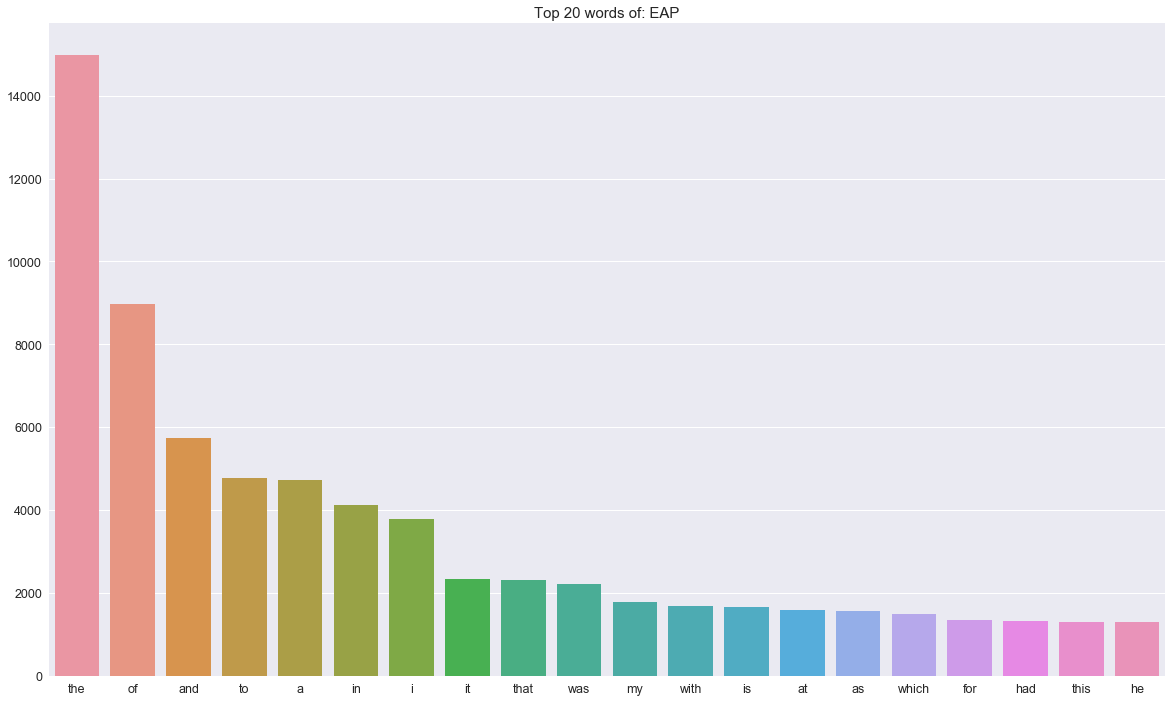

In [166]:
plot_top_20_words('EAP')

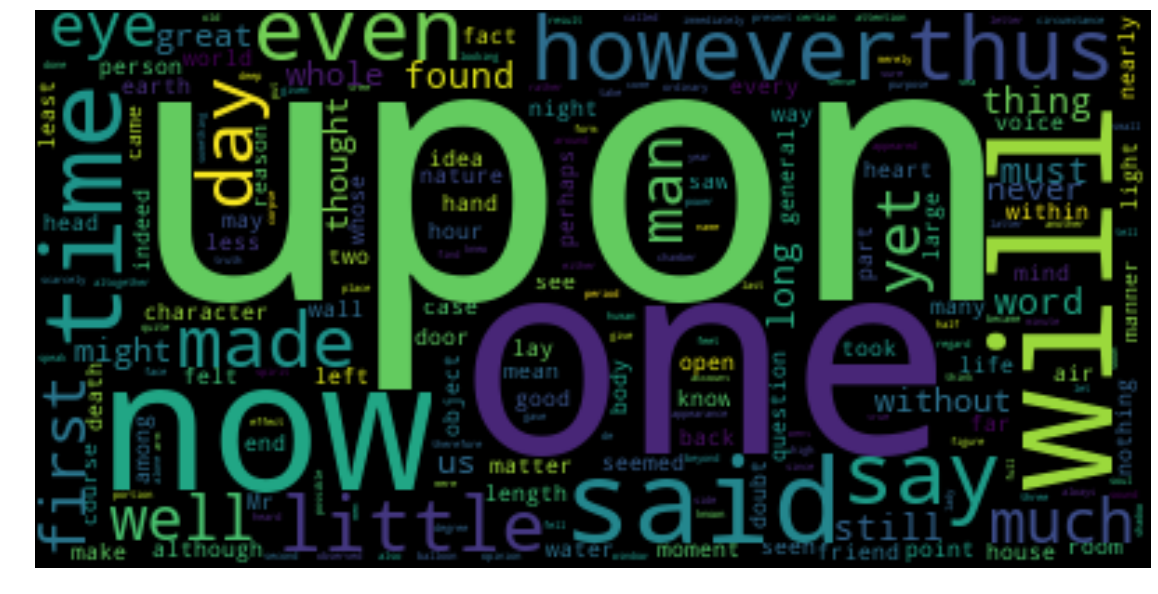

In [167]:
wordcloud = WordCloud().generate(str(combined[combined.author=='EAP'].text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### HPL

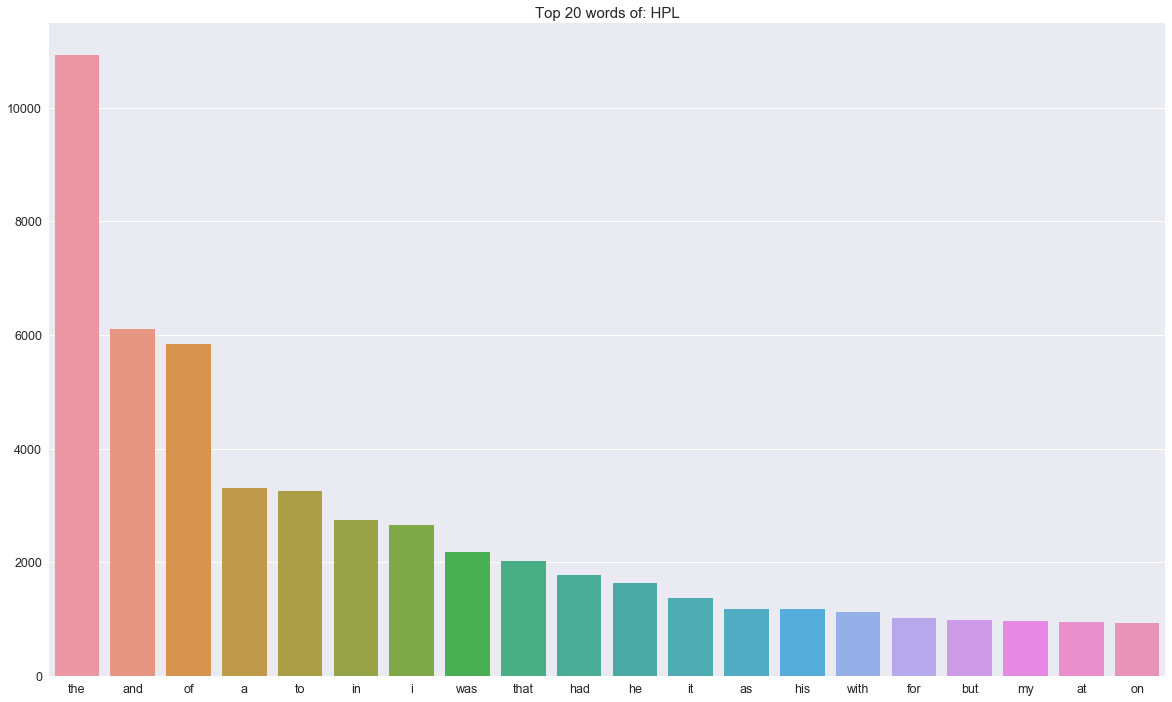

In [168]:
plot_top_20_words('HPL')

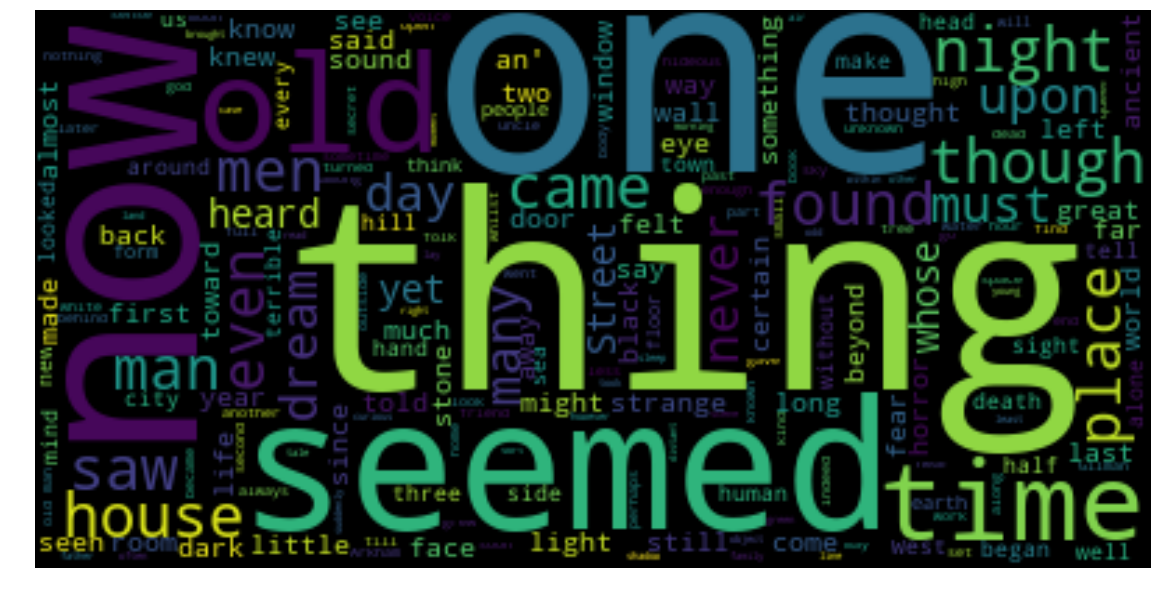

In [169]:
wordcloud = WordCloud().generate(str(combined[combined.author=='HPL'].text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### MWS

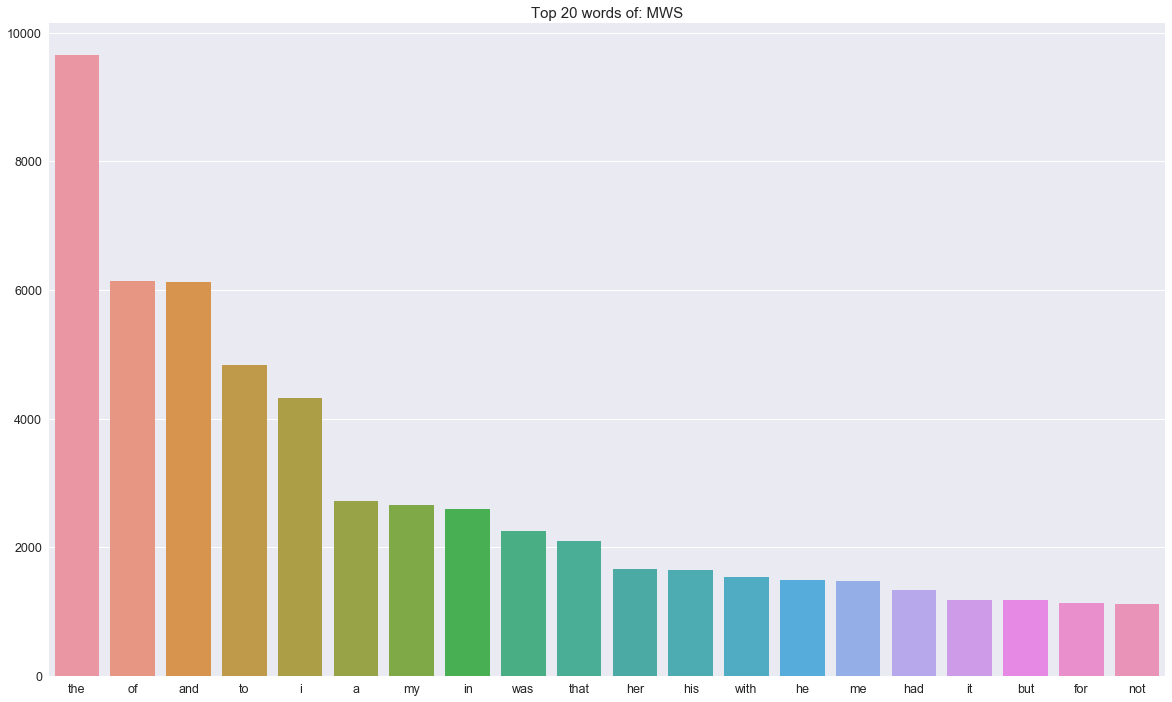

In [170]:
plot_top_20_words('MWS')

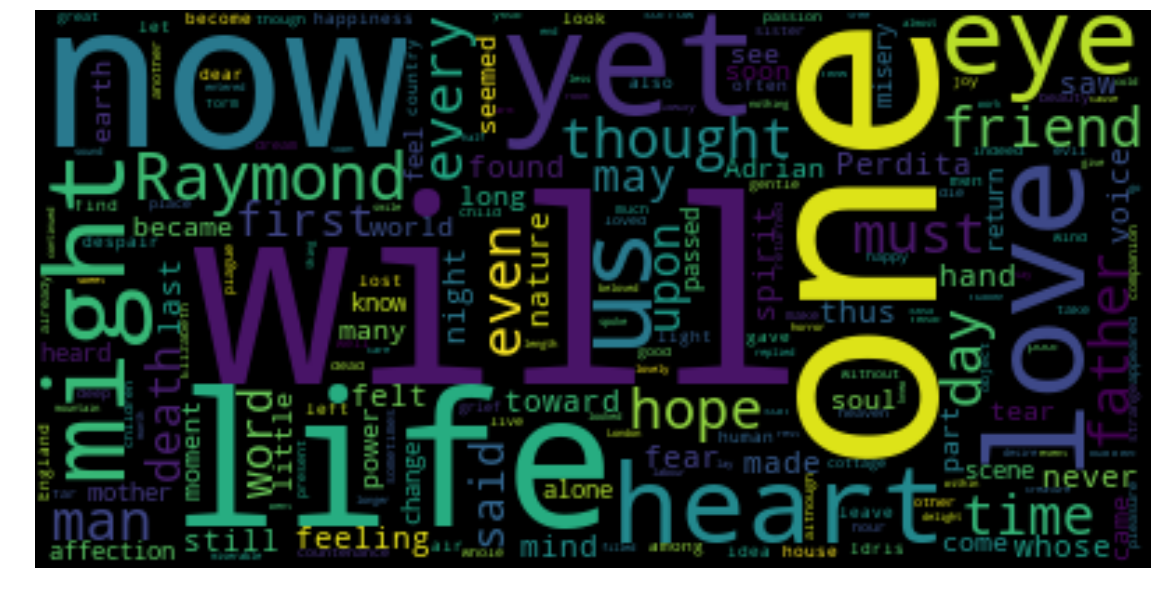

In [171]:
wordcloud = WordCloud().generate(str(combined[combined.author=='MWS'].text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Judging by the top 20 most common words used by the 3 authors, it appears that they are very similar. Words such as 'the', 'and', 'of', and 'to' and 'a' tend to come up very frequently. It turns out that simply using the most frequency words alone will not help in differentiating across the 3 different authors.

### Feature Engineering with re

Before using the Natural Language ToolKit (NLTK), let's think about some features we can use to predict the author which wrote the text. Here are some examples of features we can generate:

1. Length of sentence - If we believe certain authors tend to be more verbose, then the length of sentence can help us identify these authors better.
2. Number of words - Similar to the length of sentence, this captures the author's verbosity.
3. Average number of capital letters - Some authors may tend to use more capital letters on average in their writing.
4. Average word length - Some authors may tend to use longer words compared to their counterparts.
5. Word length variance - Certain authors may prefer to use words of different length, while others prefer to use words of similar length. Can this feature predict the author?
6. Reading Ease - It may turn out that certain authors may write for different kinds of readers - reading ease could potentially be used as a feature to differentiate authors.
7. Number of Unique Words - Some authors may prefer to use many unique words in their sentence, while others prefer to use similar words.

In [172]:
# add features using re
def clean_text(text):
    cleaned_text = text.translate(None, string.punctuation)
    return ' '.join([word.lower() for word in cleaned_text.split(' ')])

def feat_eng_re():
    # Sentence Length
    combined['sent_length'] = combined.text.apply(lambda x: len(x))
    
    # Number of Words
    combined['no_of_words'] = combined.text.apply(lambda text: len(text.split(' ')))
    
    # Average Number of Capital Letters
    combined['avg_cap_letter'] = (combined
                              .text
                              .apply(lambda x: 
                                     len(re.findall('[A-Z][A-Za-z]+', x))) /
                              combined.no_of_words)
    
    # Average Word Length
    combined['avg_word_length'] = combined.sent_length/combined.no_of_words
    
    # Word Length Variance
    combined['word_len_var'] = combined.text.apply(lambda text: np.var([len(word) 
                                                                    for word in text.split(' ')]))
    
    # Reading Ease
    combined['reading_ease'] = combined.text.apply(lambda text: textstat.flesch_reading_ease(text))
    
    # Number of Unique Words
    cleaned_text = combined.text.apply(clean_text)
    combined['unique_words'] = cleaned_text.apply(lambda text: len(set(text.split(' '))))/combined.no_of_words
    
feat_eng_re()

After the creation of these features, let's take a look at their distributions according to the 3 authors!

##### Sentence Length

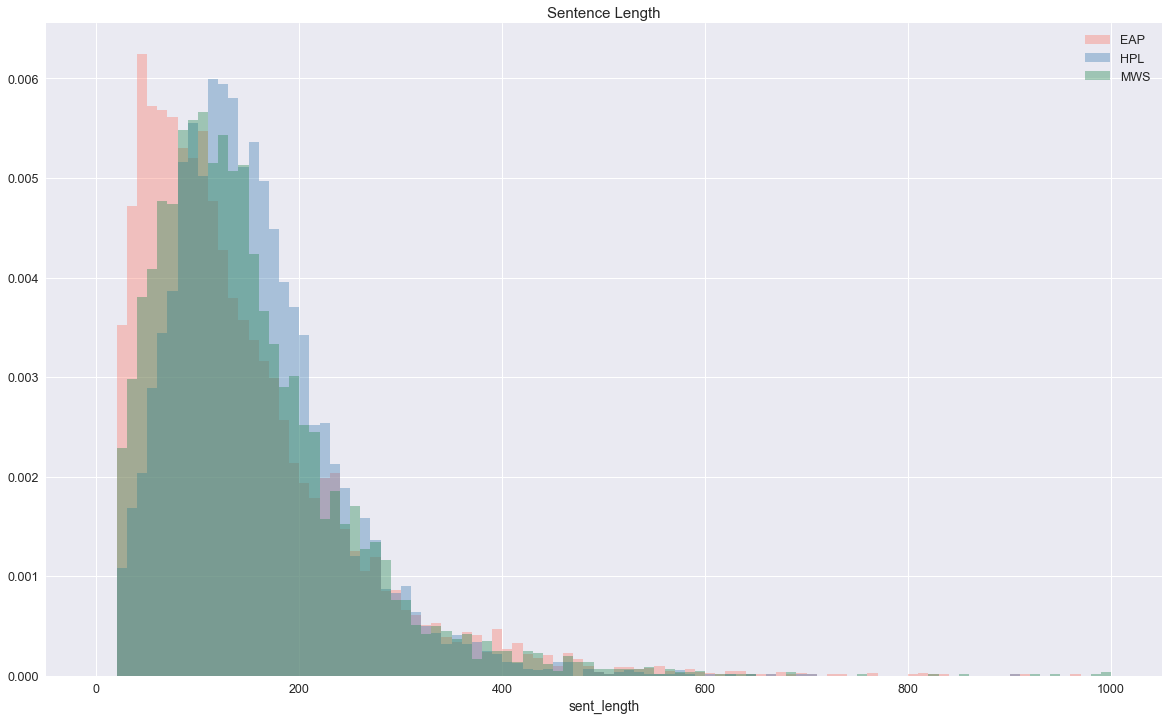

In [173]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].sent_length, color = 'salmon', 
             bins=np.linspace(0, 1000, 101), kde=False, norm_hist=True, label = 'EAP')
sns.distplot(combined[combined.author == 'HPL'].sent_length, color = 'steelblue', 
             bins=np.linspace(0, 1000, 101), kde=False, norm_hist=True, label = 'HPL')
sns.distplot(combined[combined.author == 'MWS'].sent_length, color = 'seagreen', 
             bins=np.linspace(0, 1000, 101), kde=False, norm_hist=True, label = 'MWS')

plt.title('Sentence Length')
plt.legend()
plt.show()

On average, the 3 authors tend to write sentences of equal length (about 200 - 300 characters). We do note that the author, Lovecraft writes relatively long sentences, while Poe writes relatively short sentences. 

##### Word Length

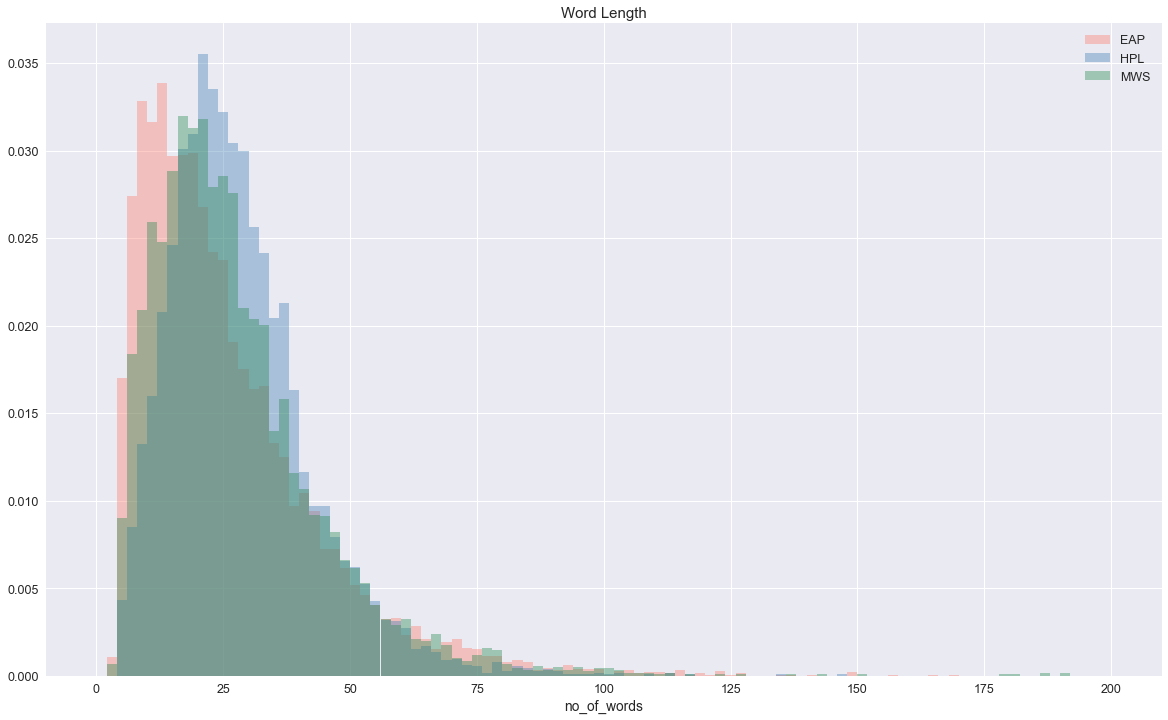

In [174]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].no_of_words, color = 'salmon',
             bins=np.linspace(0, 200, 101), kde=False, norm_hist=True, label = 'EAP')
sns.distplot(combined[combined.author == 'HPL'].no_of_words, color = 'steelblue', 
             bins=np.linspace(0, 200, 101), kde=False, norm_hist=True, label = 'HPL')
sns.distplot(combined[combined.author == 'MWS'].no_of_words, color = 'seagreen', 
             bins=np.linspace(0, 200, 101), kde=False, norm_hist=True, label = 'MWS')

plt.title('Word Length')
plt.legend()
plt.show()

The word length feature appears to be strongly correlated with the sentence length feature. This isn't surprisingly at all. (**Why?**)

##### Number of Capital Letters

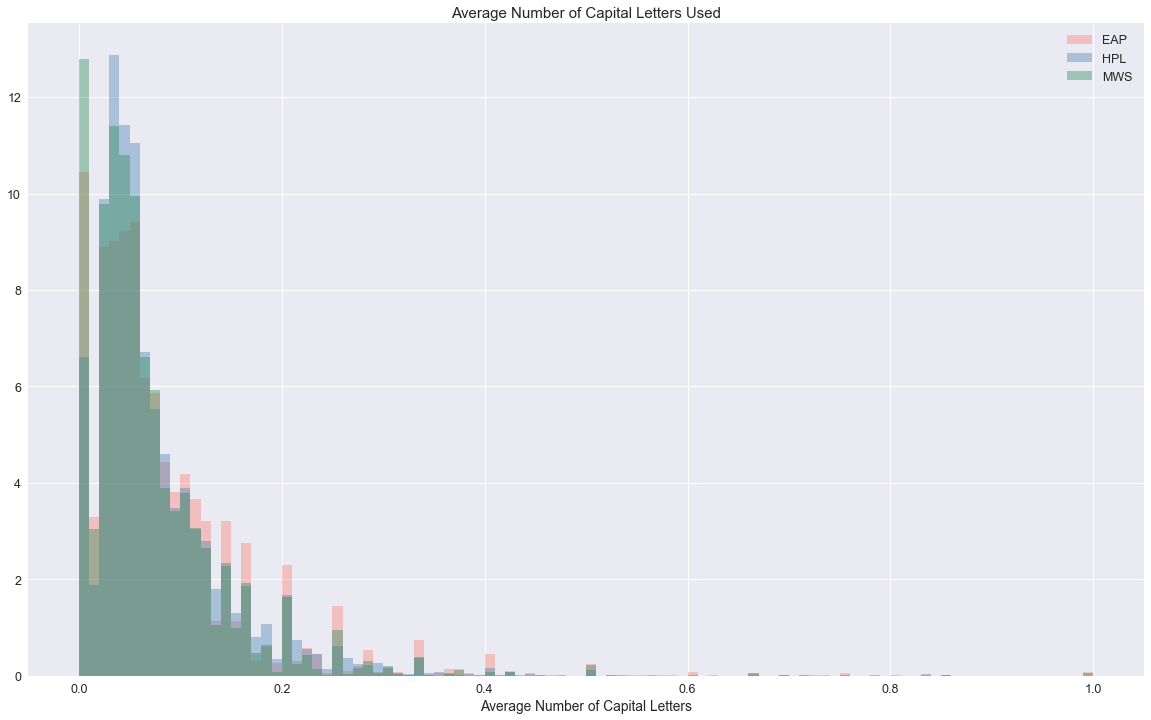

In [175]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].avg_cap_letter, color='salmon', label = 'EAP',
             bins = np.linspace(0, 1, 101), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'HPL'].avg_cap_letter, color='steelblue', label = 'HPL',
             bins = np.linspace(0, 1, 101), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'MWS'].avg_cap_letter, color='seagreen', label = 'MWS',
             bins = np.linspace(0, 1, 101), kde=False, norm_hist=True)
plt.title("Average Number of Capital Letters Used")
plt.xlabel('Average Number of Capital Letters')
plt.legend()

plt.show()

On average, the number of capital letters used in a sentence doesn't seem to be terribly informative of the target label. We do note that on average, all 3 authors use similar amounts of capital letters.

##### Average Word Length

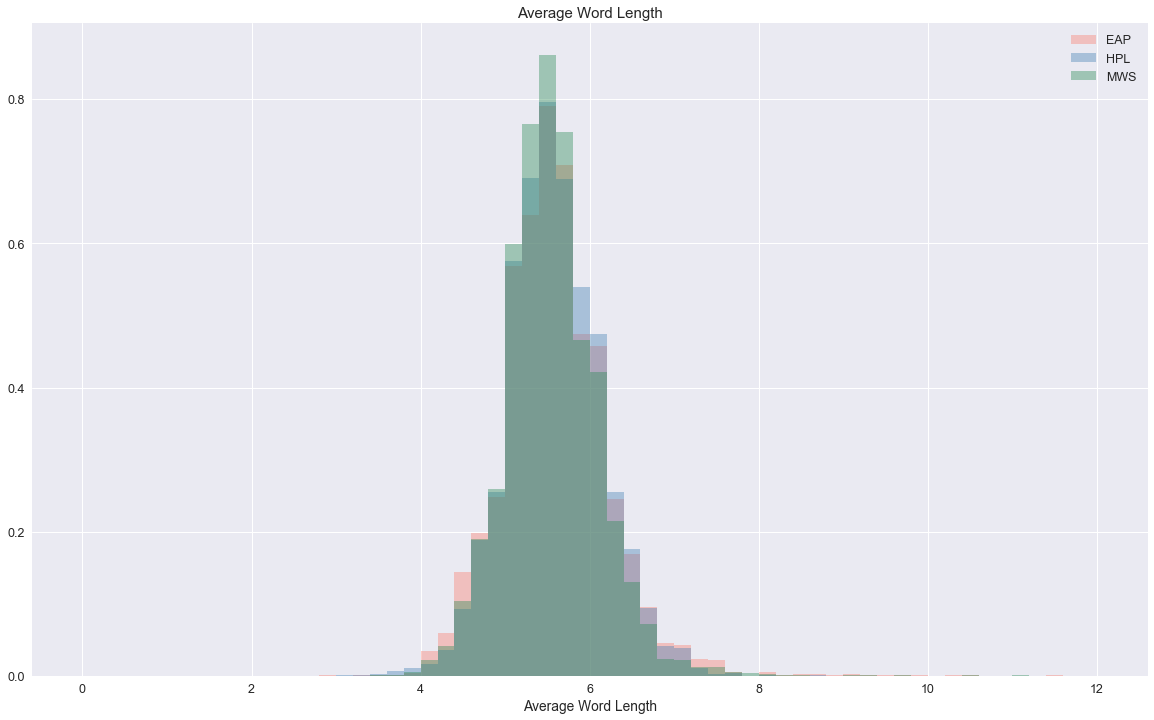

In [176]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].avg_word_length, color='salmon', label = 'EAP',
             bins = np.linspace(0, 12, 61), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'HPL'].avg_word_length, color='steelblue', label = 'HPL',
             bins = np.linspace(0, 12, 61), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'MWS'].avg_word_length, color='seagreen', label = 'MWS',
             bins = np.linspace(0, 12, 61), kde=False, norm_hist=True)
plt.title("Average Word Length")
plt.xlabel('Average Word Length')
plt.legend()

plt.show()

On average, we note that the average word length across the 3 authors don't seem to deviate too much. Most of the words fall between 4 to 8 characters. However, Mary Shelley tends to use words that contains only 5-6 characters, while Edgar Allen Poe tends to use words which are really short (2-3 characters; stopwords?) and really long.

#### Word Length Variance

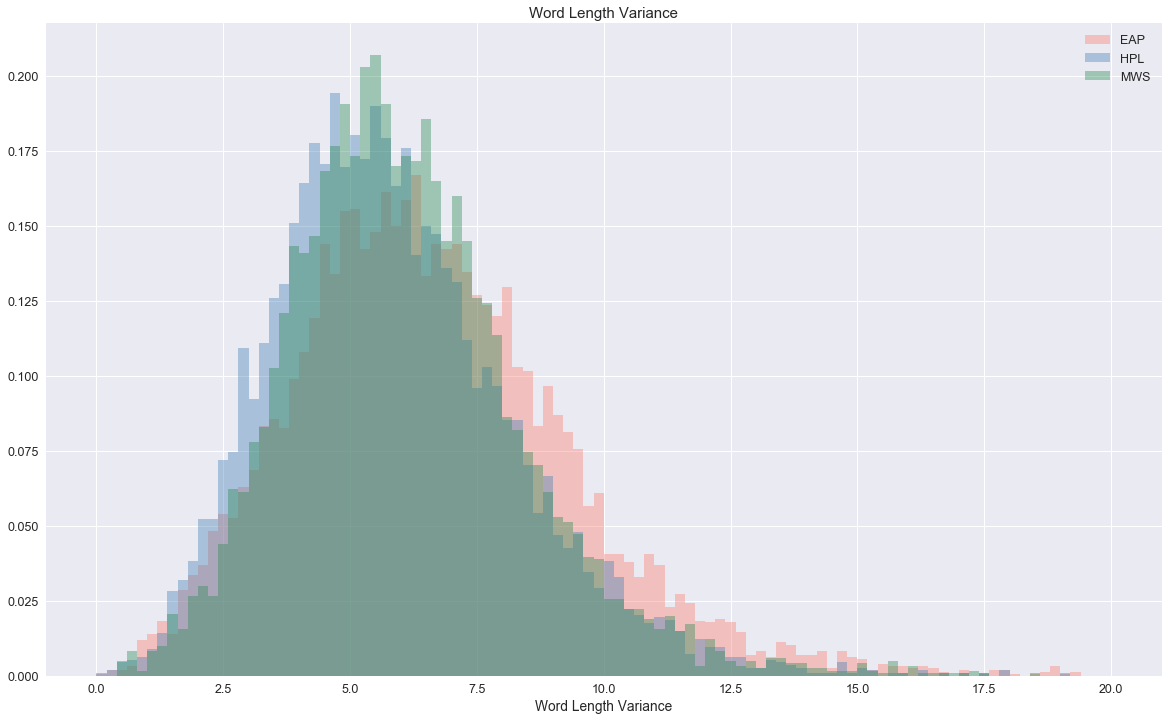

In [177]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].word_len_var, color='salmon', label = 'EAP',
             bins = np.linspace(0, 20, 101), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'HPL'].word_len_var, color='steelblue', label = 'HPL',
             bins = np.linspace(0, 20, 101), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'MWS'].word_len_var, color='seagreen', label = 'MWS',
             bins = np.linspace(0, 20, 101), kde=False, norm_hist=True)
plt.title("Word Length Variance")
plt.xlabel('Word Length Variance')
plt.legend()

plt.show()

Edgar Allen Poe seems to enjoy using words of different length in his sentences, while H.P. Lovecraft doesn't seem to like it as much. The word length variance of Mary Shelley's sentences tend to stay in the middle...

#### Reading Ease

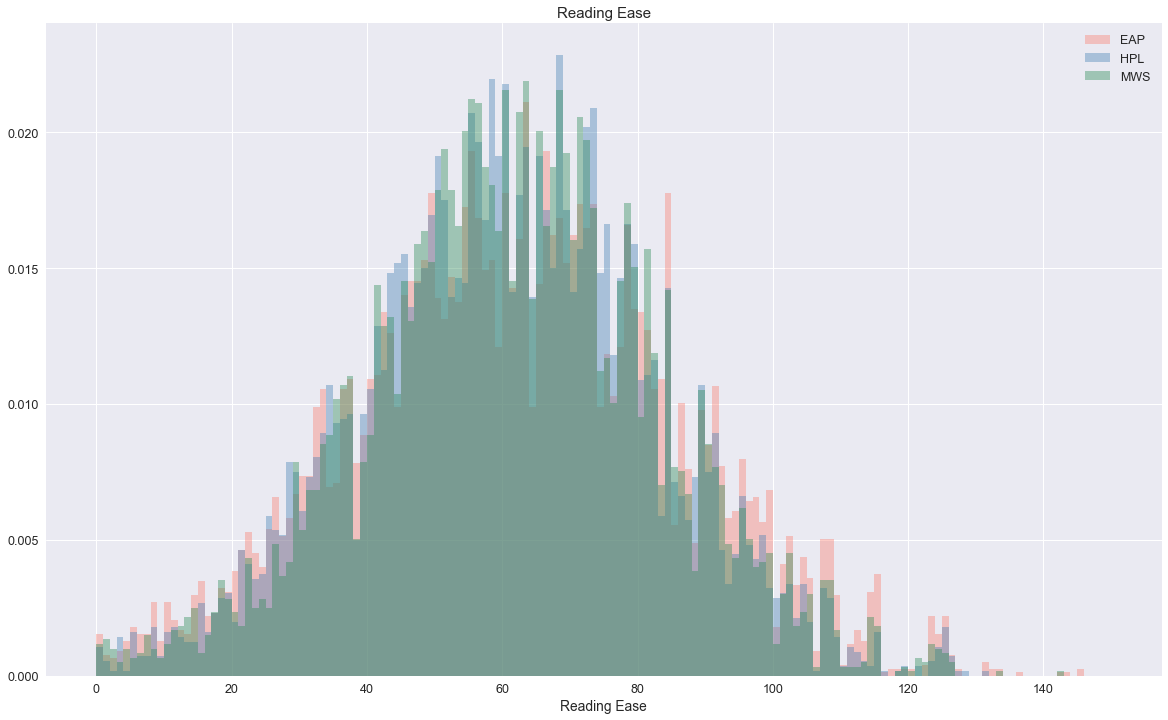

In [178]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].reading_ease, color='salmon', label = 'EAP',
             bins = np.linspace(0, 150, 151), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'HPL'].reading_ease, color='steelblue', label = 'HPL',
             bins = np.linspace(0, 150, 151), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'MWS'].reading_ease, color='seagreen', label = 'MWS',
             bins = np.linspace(0, 150, 151), kde=False, norm_hist=True)
plt.title("Reading Ease")
plt.xlabel('Reading Ease')
plt.legend()

plt.show()

The reading ease feature doesn't seem to be a particularly strong predictor of the author of a specific sentence. However, we do note that the texts from Edgar Allen Poe exhibit a strong variance for this feature.

#### Unique Words

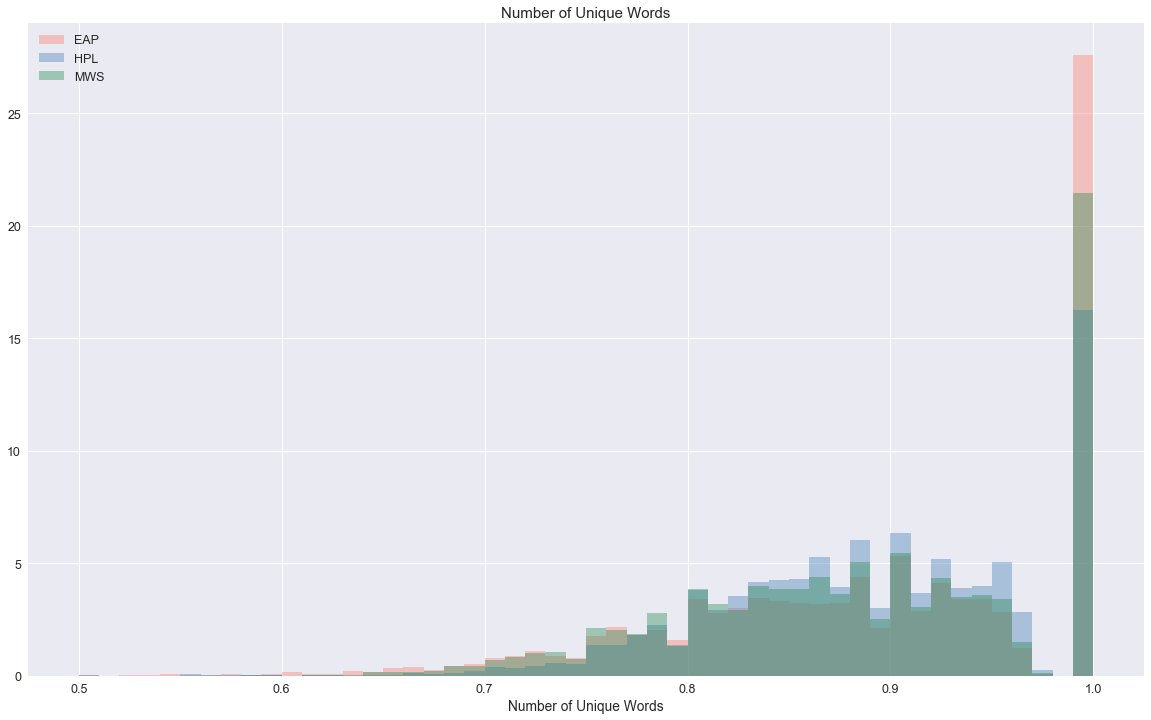

In [179]:
plt.figure(figsize=(20, 12))

sns.distplot(combined[combined.author == 'EAP'].unique_words, color='salmon', label = 'EAP',
             bins = np.linspace(0.5, 1, 51), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'HPL'].unique_words, color='steelblue', label = 'HPL',
             bins = np.linspace(0.5, 1, 51), kde=False, norm_hist=True)
sns.distplot(combined[combined.author == 'MWS'].unique_words, color='seagreen', label = 'MWS',
             bins = np.linspace(0.5, 1, 51), kde=False, norm_hist=True)
plt.title('Number of Unique Words')
plt.xlabel('Number of Unique Words')
plt.legend()

plt.show()

In terms of the number of unique words used, we observe that Poe tends to use many different words in his texts, while Mary Shelley tends to use a high proportion of unique words. H.P. Lovecraft seems to be a fan of certain words.

Let's take a quick look at the correlation across the different features to make sure that the problem of multicollinearity does not happen.

In [180]:
def label_binarizer():
    combined['EAP'] = map(int, combined.author == 'EAP')
    combined['HPL'] = map(int, combined.author == 'HPL')
    combined['MWS'] = map(int, combined.author == 'MWS')
    
label_binarizer()

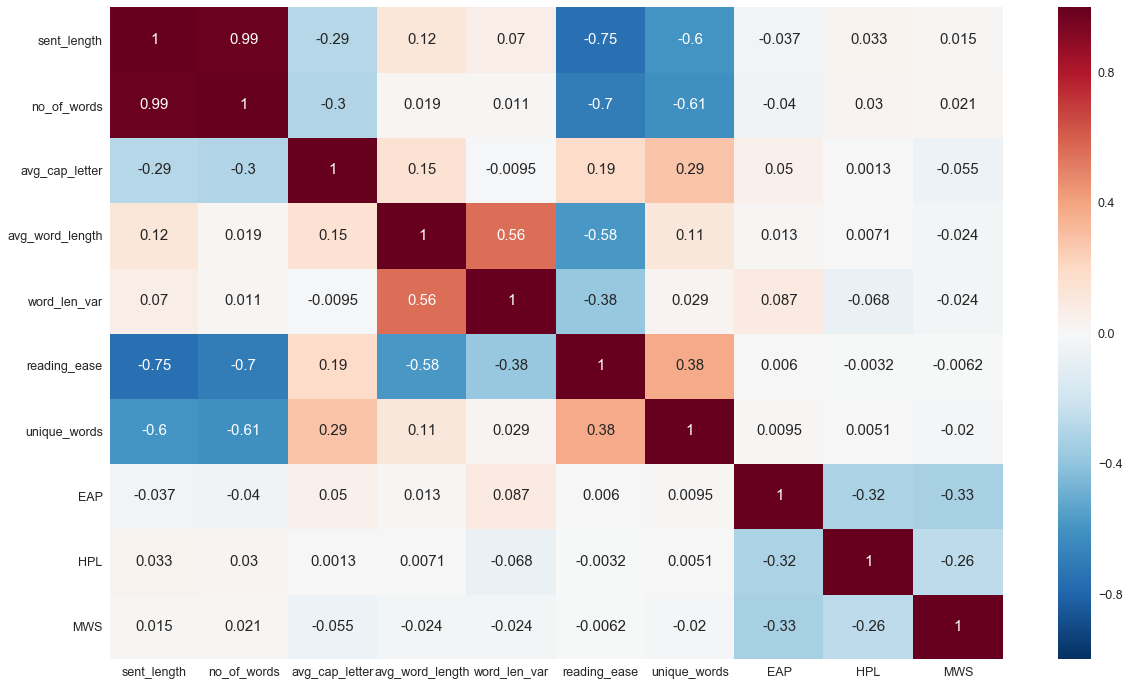

In [181]:
plt.figure(figsize=(20,12))
sns.heatmap(combined.corr(), annot=True)
plt.show()

Let's remove the sent_length feature, as it appears to be highly correlated with our other feature, no_of_words.

In [182]:
del combined['sent_length']

### Feature Engineering with NLTK

Let's use the Natural Language Toolkit library in Python to generate more features!

#### Text Cleaning

First, we remove punctuations from the text column of our combined dataframe, and convert capital letters into small letters. After which, we will remove stopwords using `nltk`'s `stopwords`.

In [183]:
from nltk.corpus import stopwords
def clean_text(text):
    # Remove punctuations from the text
    cleaned_text = text.translate(None, string.punctuation)
    # Converting all upper cases to lower cases
    cleaned_text = [word.lower() for word in cleaned_text.split(' ')]
    # Removing stopwords (takes a relatively longer amount of time)
    return ' '.join([word for word in cleaned_text if word not in stopwords.words('english')])

combined['cleaned_text'] = combined.text.apply(clean_text)

Before we conduct any processing on our stemmed text, let's try to identify whether the number of punctuation marks in a particular text can help us potentially identify the author who wrote the text.

In [184]:
# Adding the number of punctuation marks as features in our combined dataframe
def feat_eng_punc_marks():
    combined['fullstops'] = combined.text.apply(lambda text: len(re.findall('\.', text)))/combined.no_of_words
    combined['commas'] = combined.text.apply(lambda text: len(re.findall('\,', text)))/combined.no_of_words
    combined['single_inv_commas'] = combined.text.apply(lambda text: len(re.findall("\'", text)))/combined.no_of_words
    combined['double_inv_commas'] = combined.text.apply(lambda text: len(re.findall('\"', text)))/combined.no_of_words
    combined['semicolons'] = combined.text.apply(lambda text: len(re.findall('\;', text)))/combined.no_of_words
    combined['colons'] = combined.text.apply(lambda text: len(re.findall('\:', text)))/combined.no_of_words
    
feat_eng_punc_marks()

After adding the number of features, let's find out whether if the number of various punctuation marks can help us identify the target label.

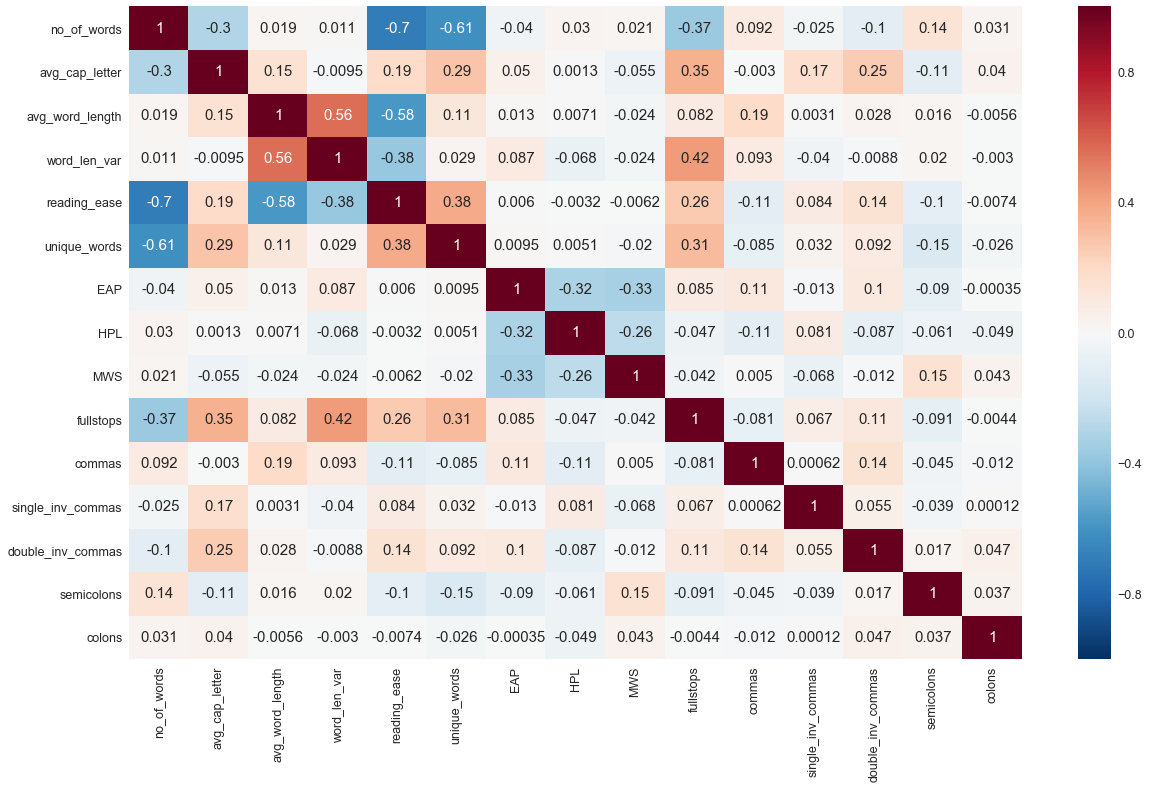

In [185]:
plt.figure(figsize=(20,12))
sns.heatmap(combined.corr(), annot=True)
plt.show()

As it turns out, these features are pretty informative.

#### Most Common Words

Next, let's take a look at the most common terms.

In [186]:
def top_20_words(author):
    # Return a cleaned series of lists of words
    author_cleaned = combined[combined.author == author].cleaned_text.str.split(' ')

    # Returns a dictionary where keys are words and values are the word counts
    dict_of_word_count = {}
    for text in author_cleaned:
        for word in text: dict_of_word_count[word] = dict_of_word_count.get(word, 0) + 1
    
    # Returns a sorted dictionary based on the number of word counts (top 20 words only)
    return sorted(dict_of_word_count.iteritems(), key=lambda(v,k): (k,v), reverse=True)[0:20]

def plot_top_20_words(author):
    plt.figure(figsize=(20, 12))
    topwords = top_20_words(author)
    
    words, freq = zip(*topwords)[0], zip(*topwords)[1]
    
    x_pos = np.arange(len(words)) 
    sns.barplot(x_pos, freq)
    plt.xticks(x_pos, words)
    plt.title('Top 20 cleaned_text terms of: ' + author)
    plt.show()

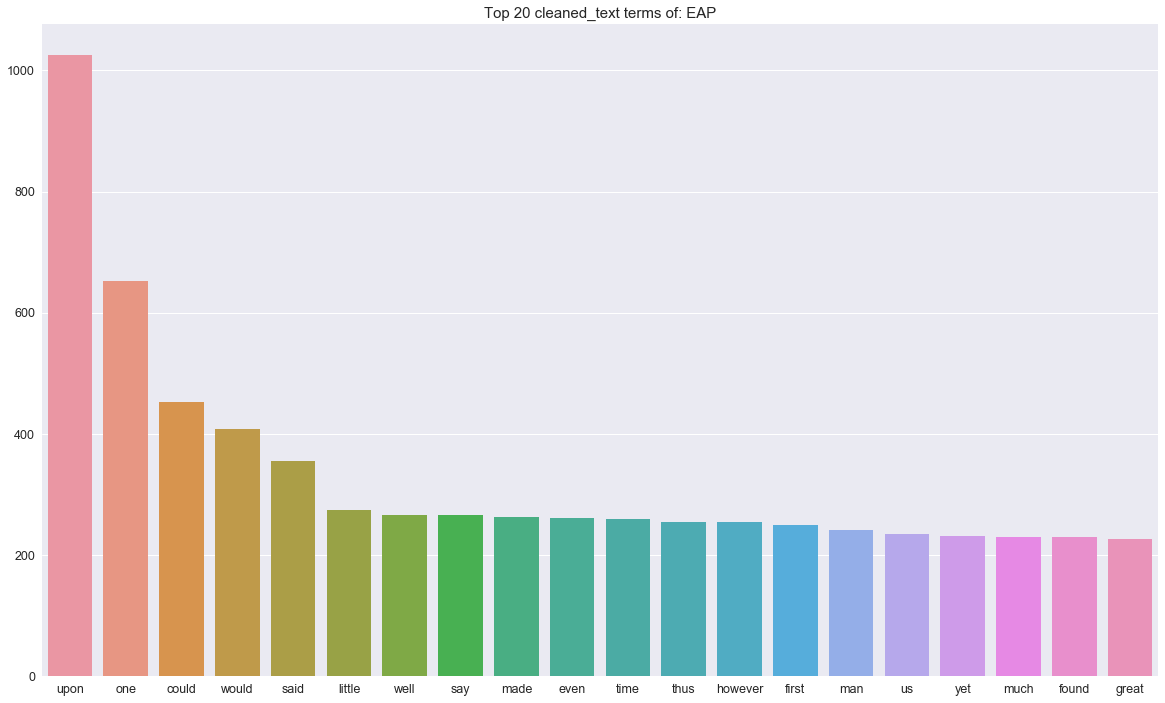

In [187]:
# Plotting top words for Edgar Allen Poe
plot_top_20_words('EAP')

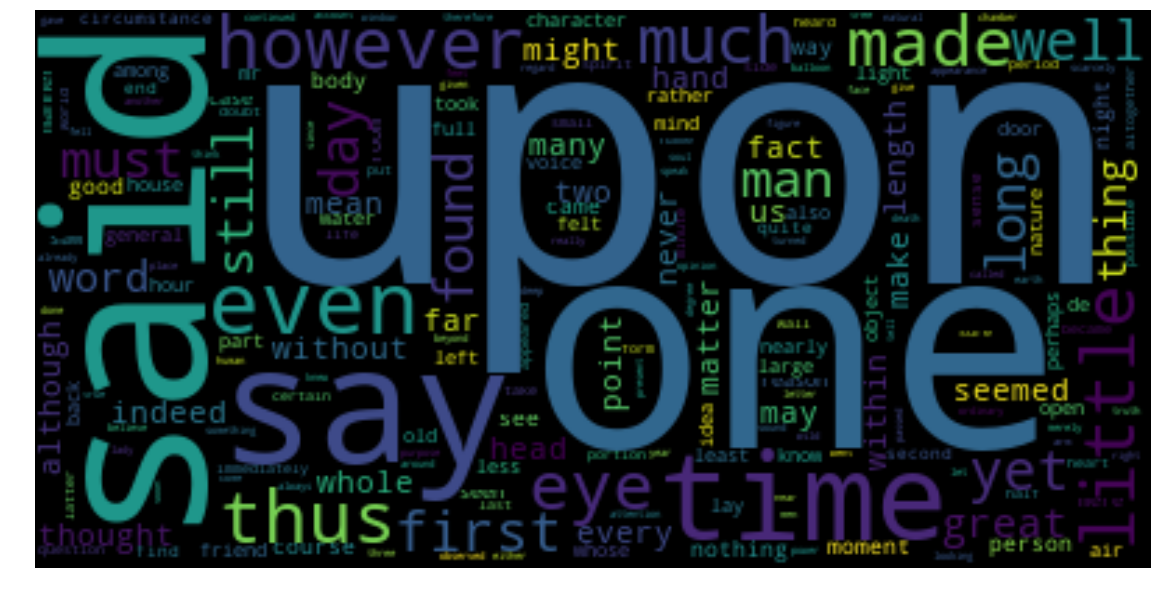

In [188]:
wordcloud = WordCloud().generate(str(combined[combined.author=='EAP'].cleaned_text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

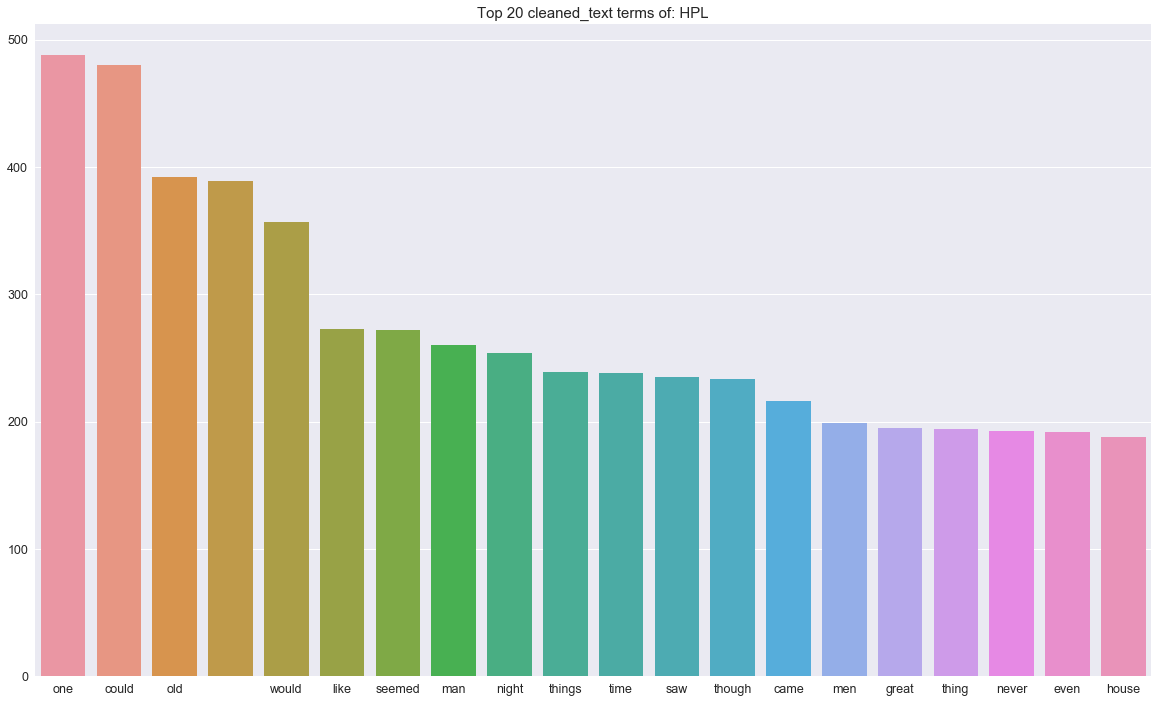

In [189]:
# Plotting top lemmatized words for H.P. Lovecraft
plot_top_20_words('HPL')

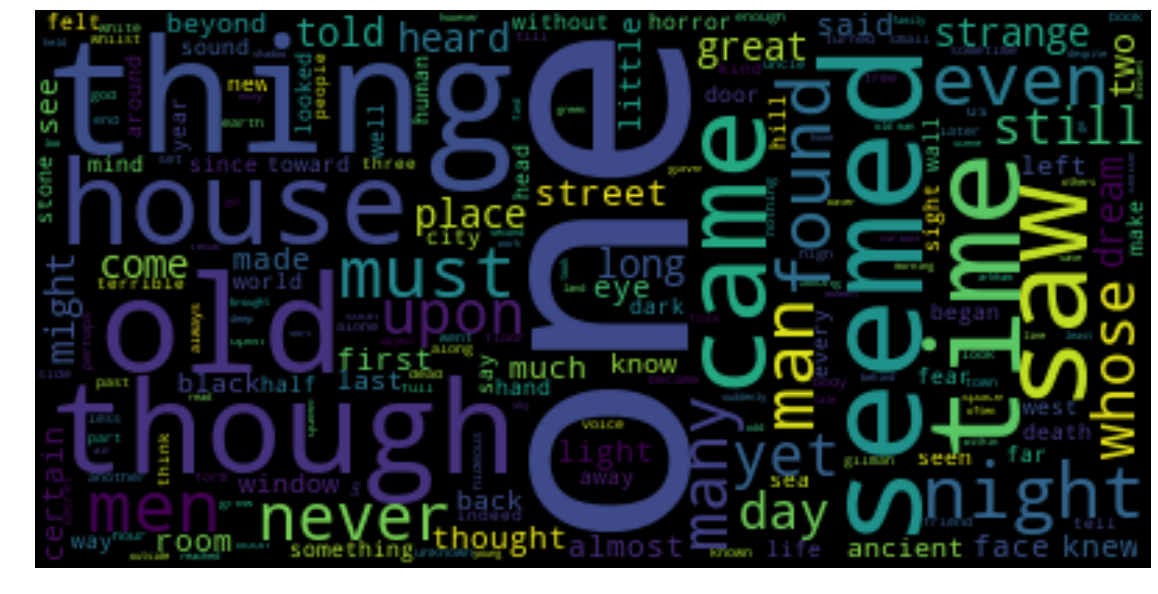

In [190]:
wordcloud = WordCloud().generate(str(combined[combined.author=='HPL'].cleaned_text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

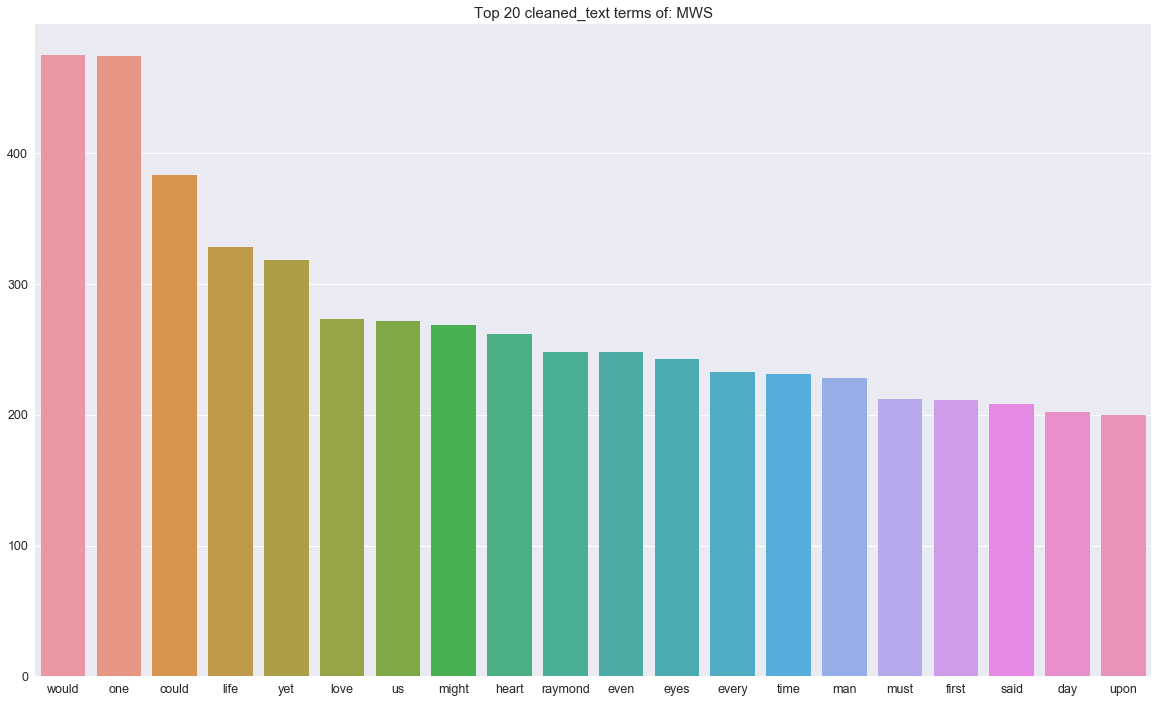

In [191]:
# Plotting top lemmatized words for Mary Shelley
plot_top_20_words('MWS')

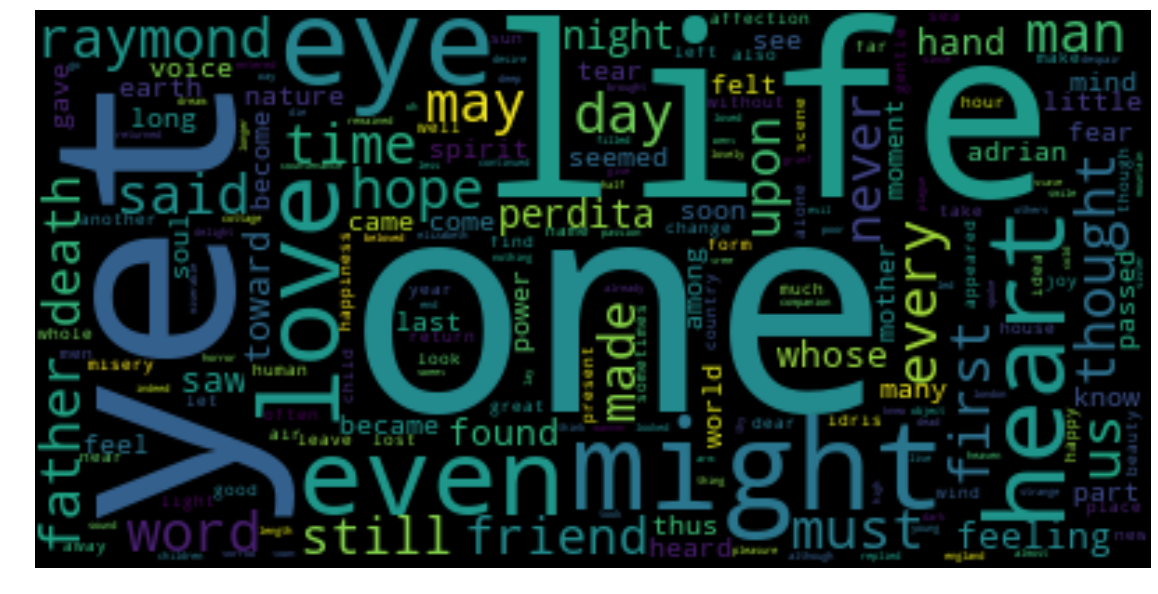

In [192]:
wordcloud = WordCloud().generate(str(combined[combined.author=='MWS'].cleaned_text.tolist()))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

After removing stopwords from the cleaned dataframe on our dataframe, there are still many common words, such as 'one' and 'seemed'. As these words frequently occur in the corpus across all authors, they are not really informative. Can we create informative features then?

#### Part-of-Speech Tagging

According to NLTK, part-of-speech tagging, or POS-tagging is the process of classifying words into their parts of speech and labeling them accordingly. Parts of speech are also known as word classes or lexical categories. The collection of tags used for a particular task is known as a tagset.

For our analysis, we can look at the number of nouns, verbs and adjectives in each sentence, and potentially use them as features. Intuitively, the writing style differs from authors to authors. We would expect certain authors to use more nouns, verbs or adjectives relative to other authors. Let's make use of this observation to create more features.

In [193]:
# Conduct POS Tagging (takes a bit of time to run this code)
pos_tags = (combined.text.apply(lambda text: nltk.pos_tag(nltk.word_tokenize(text.decode('utf-8')))))

In [194]:
def pos_tag_count(list_of_postag):
    # Return dictionary of dataframes with postags as keys and counts as values
    dict_of_postags = {}
    for tag in list_of_postag:
        dict_of_postags[tag[1]] = dict_of_postags.get(tag[1], 0) + 1
    return dict_of_postags
        
postags_df = pd.DataFrame(pos_tags.apply(pos_tag_count).to_dict()).T

Let's remove the punctuation counts from the POS Tagging dataframe, as we have previously accounted for them.

In [195]:
# Removing punctuation counts
pos_tag_col = [col for col in postags_df.columns if re.findall('[A-Z]+', col)]

# Fill NA values with 0, as there were no occurrences
postags_df_ = postags_df[pos_tag_col].fillna(0)

To check which tags are most indicative of the target label, we can use a correlation matrix to estimate their importance.

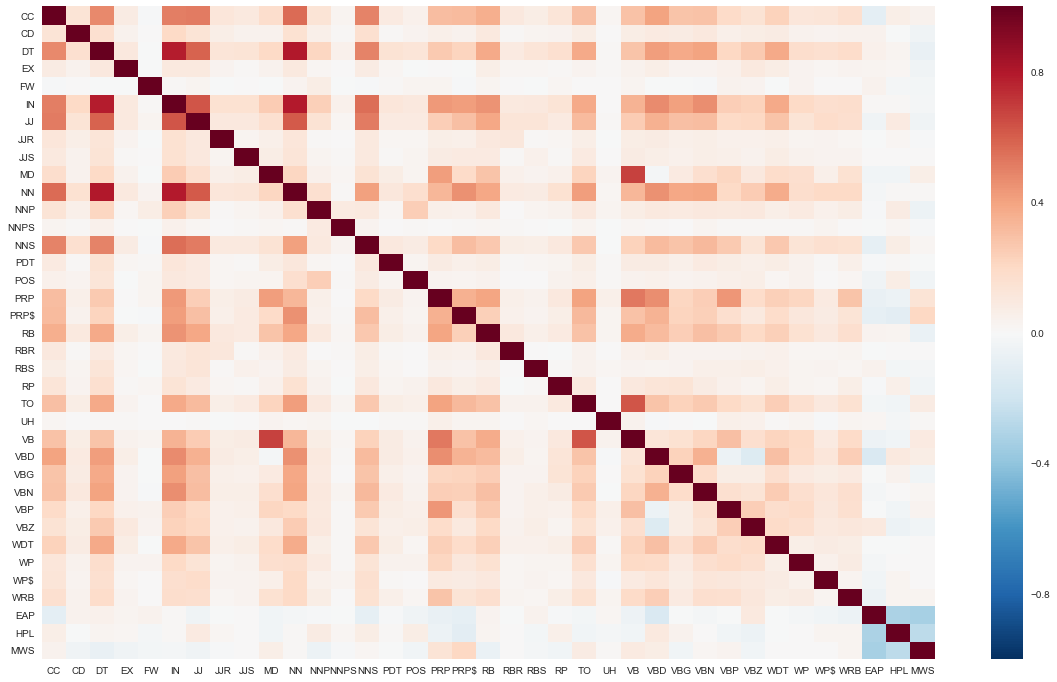

In [196]:
def postag_label_binarizer():
    postags_df_['EAP'] = map(int, combined.author == 'EAP')
    postags_df_['HPL'] = map(int, combined.author == 'HPL')
    postags_df_['MWS'] = map(int, combined.author == 'MWS')

postag_label_binarizer()
    
sns.set(font_scale=1)
plt.figure(figsize=(20,12))
sns.heatmap(postags_df_.corr())
plt.show()

It appears that most of them are weakly correlated with our features! Nonetheless, we can include them in our model.

In [197]:
del postags_df_['EAP']
del postags_df_['HPL']
del postags_df_['MWS']

combined = pd.merge(combined, postags_df_,
                    left_index=True, right_index=True)

### Feature Engineering with Scikit-Learn

For this segment, I relied heavily on [SRK's kernel](https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author), which was included as a reference earlier in the iPython Notebook. Please check his kernel out!

#### Step 1:
After we have engineered features with re and NLTK, let's try to generate more features using Scikit-Learn! We can use the TfidfVectorizer to find words that occur a minimum amount of times in the dataframe. In our case, we will only focus only on unigrams, bigrams and trigrams, which occur at least 2 times.

Basically, the [tf-idf](https://en.wikipedia.org/wiki/Tf–idf) (term frequency-inverse document freqency) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 

Intuitively, you would expect relatively **important** words to occur frequently within a specific text, but does not appear frequently across the corpus. Think of the words 'Sherlock' and 'Holmes' - these words shouldn't occur in many different texts! On the other hand, while common words such as 'and', 'the' and 'of' appears frequently occur in the same texts, the fact that it appears across many other texts imply that it is unimportant.

We will proceed to conduct dimensionality reduction on our tfidf matrix to reduce the (computational) complexity of the dataframe. We can do so using `sklearn.decomposition`'s `TruncatedSVD` method to reduce the dimensions of our tfidf dataframe.

The dimensionality-reduced tfidf matrix will be appended as part of our features for the final prediction.

#### Step 2:
After we have created our new features using `sklearn`'s `TfidfVectorizer` function and performed dimensionality reduction on our dataframe, we can proceed to generate additional bag of words (bow) features using `sklearn`'s `CountVectorizer` function.

The CountVectorizer features will be used to predict for the author using a simple Multinomial Naive Bayes model, and the predictions from the model will be used as inputs for our final prediction.

In [198]:
def train_test_split_df():
    return combined.iloc[:nrow_train], combined.iloc[nrow_train:]

X_train, X_test = train_test_split_df()

In [199]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TfidfVectorizor to remove english stopwords and tokens that don't appear in at least 2 documents
# Only focus on unigrams, bigrams and trigrams
min_df = 2
ngram_range=(1,3)

def vectorize_tfidf(min_df, ngram_range):
    vect = TfidfVectorizer(min_df=min_df, 
                           ngram_range=ngram_range, 
                           stop_words='english')
    
    # Fit on the whole dataframe
    full_tfidf = vect.fit_transform(combined.text)
    
    # Conduct transformation on the training and test dataframe
    train_tfidf = vect.transform(X_train.text)
    test_tfidf = vect.transform(X_test.text)
    
    return full_tfidf, train_tfidf, test_tfidf

full_tfidf, train_tfidf, test_tfidf = vectorize_tfidf(min_df=min_df, ngram_range=ngram_range)

In [200]:
from sklearn.decomposition import TruncatedSVD

def dim_reduce_tfidf(n_comp, full_tfidf):
    # Conduct dimensionality reduction on the dataframe using Truncated SVD
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(full_tfidf)
    
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
    train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
    test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
    
    return pd.concat([train_svd, test_svd])
    
# We settle on 25 components
tfidf_sparse = dim_reduce_tfidf(n_comp=25, full_tfidf=full_tfidf)

In [201]:
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizor to remove stop_words, remove tokens that don't appear in at least 1 document,
# Focus only on unigrams, bigrams and trigrams
min_df = 1
ngram_range=(1,3)

def vectorize_count(min_df, ngram_range):
    vect = CountVectorizer(min_df=min_df, 
                           ngram_range=ngram_range, 
                           stop_words='english')

    full_count = vect.fit_transform(combined.text)
    train_count = vect.transform(X_train.text)
    test_count = vect.transform(X_test.text)
    
    return full_count, train_count, test_count

full_count, train_count, test_count = vectorize_count(min_df=min_df, ngram_range=ngram_range)

In [202]:
import scipy.sparse

count_sparse = scipy.sparse.vstack([train_count, test_count])

Let's take a quick look at the dimensions of our dataframe.

In [203]:
count_sparse

<27971x550841 sparse matrix of type '<type 'numpy.int64'>'
	with 870395 stored elements in Compressed Sparse Row format>

As it turns out, 550841 features fit the bill.

### Topic Modelling with Gensim

After feature engineering, let's conduct topic modelling to identify potential topics in the corpus! As certain authors may tend to write about certain topics - things which are closer to their hearts, we may expect the underlying topics in the corpus to be good features. To conduct topic modelling, we will use `Gensim`'s inbuilt `LdaModel`. 

Let's proceed to train our models using the cleaned corpus.

In [204]:
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer

min_df=3
ngram_range=(1,5)

vect = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range, stop_words='english')

# Fit and transform
text_train = vect.fit_transform(X_train.cleaned_text)

# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(text_train, documents_columns=False)

# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())

In order to carry out Topic Modelling, we have to supply a parameter, $k$, which notifies gensim of the number of underlying topics in the corpus. In this case, we settle on 10 different topics. In addition, let's set a random seed for reproducibility.

In [205]:
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`

random_state = 324
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10,
                                           id2word = id_map, passes = 10,
                                           random_state = random_state)

What are the 10 different topics?

In [206]:
ldamodel.show_topics(num_topics=10)

[(0,
  u'0.006*"said" + 0.005*"say" + 0.003*"knew" + 0.003*"object" + 0.003*"answer" + 0.003*"wrote" + 0.003*"dupin" + 0.003*"captain" + 0.002*"letter" + 0.002*"quiet"'),
 (1,
  u'0.004*"know" + 0.003*"quite" + 0.003*"things" + 0.003*"told" + 0.003*"dont" + 0.002*"think" + 0.002*"day" + 0.002*"island" + 0.002*"like" + 0.002*"oh"'),
 (2,
  u'0.003*"man" + 0.003*"replied" + 0.003*"night" + 0.003*"time" + 0.003*"miserable" + 0.002*"smile" + 0.002*"called" + 0.002*"good" + 0.002*"wish" + 0.002*"spirits"'),
 (3,
  u'0.004*"perdita" + 0.004*"love" + 0.003*"little" + 0.003*"heart" + 0.003*"dear" + 0.003*"raymond" + 0.003*"old" + 0.003*"home" + 0.003*"shall" + 0.003*"sister"'),
 (4,
  u'0.003*"minutes" + 0.003*"saw" + 0.003*"coming" + 0.003*"came" + 0.003*"taken" + 0.003*"spoke" + 0.002*"vessel" + 0.002*"genius" + 0.002*"left" + 0.002*"fell"'),
 (5,
  u'0.003*"night" + 0.002*"men" + 0.002*"tell" + 0.002*"life" + 0.002*"plague" + 0.002*"earth" + 0.002*"way" + 0.002*"light" + 0.002*"seen" + 0.00

Let's write a function that returns the most likely topic, given the text.

In [207]:
def most_probable_topic(text):
    
    # Transform text into Corpus
    X = vect.transform(text)
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    
    # Return topic distribution
    topic_dist = ldamodel.inference(corpus)[0]
    
    topics = [max(enumerate(corpus), key=operator.itemgetter(1))[0] for corpus in topic_dist]
    
    return topics

Now that we have obtained the topic numbers, let's convert the topics found using One-Hot Encoding. We can use the `pd.get_dummies` function from `pandas` to do so.

In [208]:
# One-hot encoding of topic number
train_topics = pd.get_dummies(most_probable_topic(X_train.cleaned_text), prefix='topic')
test_topics = pd.get_dummies(most_probable_topic(X_test.cleaned_text), prefix='topic')

# Amalgamating the 2 dataframes and converting them to sparse matrix
combined_topics = scipy.sparse.vstack([scipy.sparse.csr_matrix(train_topics), scipy.sparse.csr_matrix(test_topics)])

What are the dimensions of our combined training dataframe? Let's take a look.

In [209]:
print 'The combined topic dataset has %d rows and %d columns.' % combined_topics.shape

#### Distribution of Topic Numbers according to the different Authors

Let's take a look at how well our topics are able to differentiate between the different authors.

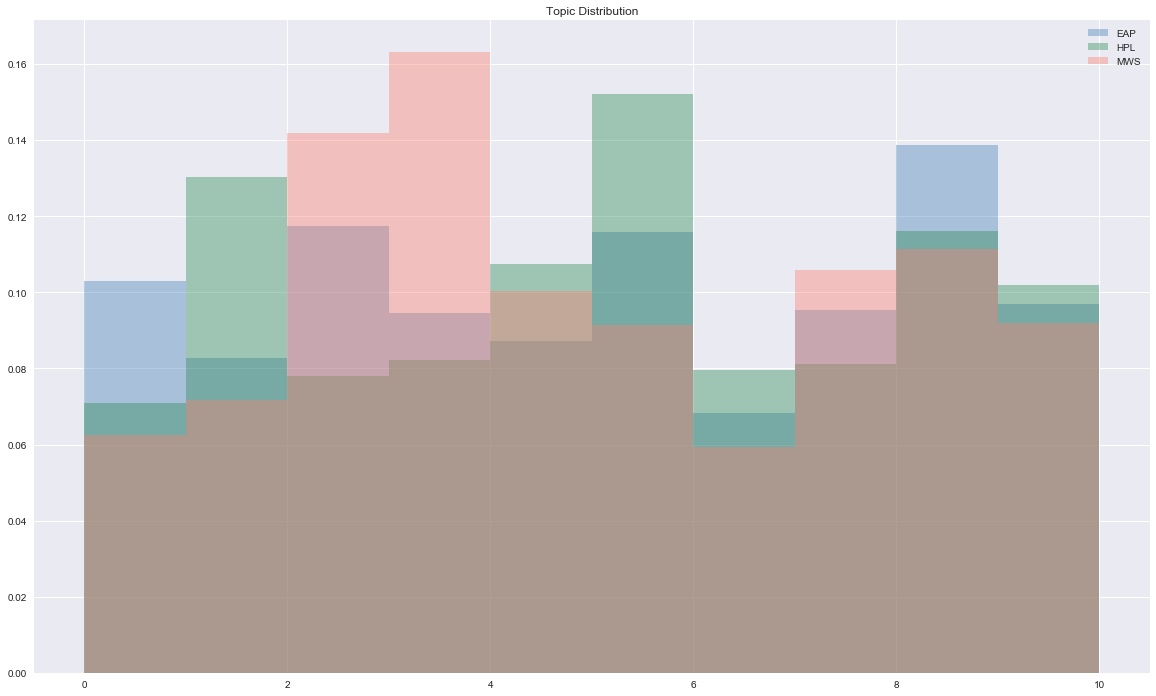

In [210]:
plt.figure(figsize=(20,12))

topics = pd.DataFrame(most_probable_topic(X_train.text))

sns.distplot(topics.iloc[combined[combined.author=='EAP'].index.values],
             bins=range(0, 11, 1), kde=False, norm_hist=True, color='steelblue', label='EAP')
sns.distplot(topics.iloc[combined[combined.author=='HPL'].index.values],
             bins=range(0, 11, 1), kde=False, norm_hist=True, color='seagreen', label='HPL')
sns.distplot(topics.iloc[combined[combined.author=='MWS'].index.values],
             bins=range(0, 11, 1), kde=False, norm_hist=True, color='salmon', label='MWS')

plt.title('Topic Distribution')
plt.legend()
plt.show()

### Feature Selection and Model Fitting

Let's select the features which we will be using for our prediction.

In [211]:
X_train.columns = [str(feat) for feat in X_train.columns.tolist()]
X_test.columns = [str(feat) for feat in X_test.columns.tolist()]
features = [feat for feat in X_train.columns.tolist() 
            if feat not in ['author', 'id', 'text', 'cleaned_text']]

df_features = pd.concat([X_train[features], X_test[features]])

In [212]:
del df_features['EAP']
del df_features['HPL']
del df_features['MWS']

sparse_features = scipy.sparse.csr_matrix(df_features)

In [213]:
X = scipy.sparse.hstack([sparse_features, 
                         combined_topics, 
                         tfidf_sparse]).tocsr()

mapping = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = X_train[:nrow_train].author.map(mapping)

X_train = pd.DataFrame(X[:nrow_train].toarray())
X_test = pd.DataFrame(X[nrow_train:].toarray())

#### Multinomial Naive Bayes

We will proceed to fit the CountVectorizer features using a Multinomial Naive Bayes model and attempt to predict for the authors in the corpus. The resulting predictions will be used as inputs for our final prediction.

In [214]:
from sklearn import metrics, model_selection, naive_bayes

def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    
    return pred_test_y, pred_test_y2, model

In [215]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([nrow_train, 3])

n_folds = 5
kfolds = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2017)

for dev_index, val_index in kfolds.split(X_train):
    X_dev, X_val = train_count[dev_index], train_count[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    pred_y_val, pred_test_y, model = runMNB(X_dev, y_dev, X_val, y_val, test_count)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))

print 'Mean cv score :', np.mean(cv_scores)
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
X_train["nb_cvec_eap"] = pred_train[:,0]
X_train["nb_cvec_hpl"] = pred_train[:,1]
X_train["nb_cvec_mws"] = pred_train[:,2]
X_test["nb_cvec_eap"] = pred_full_test[:,0]
X_test["nb_cvec_hpl"] = pred_full_test[:,1]
X_test["nb_cvec_mws"] = pred_full_test[:,2]

What was the mean cross-validation score?

In [216]:
np.mean(cv_scores)

0.45091841616567468

### Final Prediction

Next, we will use an Extreme Gradient Boosting to fit the final model using the features which were previously generated. Recall that we have the normal features (punctuation counts, word length, word length variance etc.), the topic features and the sparse tfidf matrix. We will combine these features together, along with the prediction from the Multinomial Naive Bayes model to predict for the author.

In [217]:
import xgboost as xgb

# Define a function to run Extreme Gradient Boosting
def runXGB(X_train, y_train, X_test, y_test=None, X_test2=None):
    param = {
        'objective': 'multi:softprob',
        'eta': 0.1,
        'max_depth': 3,
        'silent': 0,
        'num_class': 3,
        'eval_metric': "mlogloss",
        'min_child_weight': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.7,
        'seed': 0
    }
    
    num_rounds = 1000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(X_train, label=y_train)

    if y_test is not None:
        xgtest = xgb.DMatrix(X_test, label=y_test)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(X_test)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_y_test = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    
    if X_test2 is not None:
        xgtest2 = xgb.DMatrix(X_test2)
        pred_y_test2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    
    return pred_y_test, pred_y_test2, model

In [218]:
from sklearn import metrics, model_selection

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([nrow_train, 3])

for dev_index, val_index in kfolds.split(X_train):
    X_dev, X_val = X_train.loc[dev_index], X_train.loc[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    
    pred_y_val, pred_test_y, model = runXGB(X_dev, y_dev, X_val, y_val, X_test)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_y_val
    
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))

What is our cross-validation score?

In [219]:
np.mean(cv_scores)

0.34987161968846187

Let's submit our results to Kaggle!

In [220]:
pred = pred_full_test/5

In [221]:
submission = pd.read_csv('submission.csv')
for idx, colname in enumerate(submission.columns.tolist()):
    if colname == 'id': continue
    submission[colname] = pred[:, idx-1]

In [222]:
submission.to_csv('final_submission.csv', index=False)